In [1]:
import akshare as ak
import pandas as pd
import datetime as dt
import numpy as np
import talib as tl
import matplotlib.pyplot as plt
# import matplotlib.finance as mpf

# 数据准备
## 获取历史数据

In [2]:
def get_price(security,end_date=None,rag=1800):
    if end_date is None:
        end_date = dt.datetime.today()
    
    start_date = end_date - dt.timedelta(days=rag)    
    str_end_date = end_date.strftime('%Y%m%d')
    str_start_date = start_date.strftime('%Y%m%d')
    price = ak.stock_zh_a_hist(symbol=security, period="daily", start_date=str_start_date, end_date=str_end_date, adjust="qfq")
    price.columns = ['date','open','close','high','low','volume','turnover','amp_rate','quote_rate','quote_num','turnover_rate']
    return price


In [3]:
security='000736'

# 获取’中交地产‘的数据
zjdc = get_price(security)

## 添加均线

In [4]:
# 添加 均线
def append_ma(df):
    df['ma5'] = df['close'].rolling(window=5).mean()
    df['ma10'] = df['close'].rolling(window=10).mean()
    df['ma20'] = df['close'].rolling(window=20).mean()
    df['ma30'] = df['close'].rolling(window=30).mean()
    df['ma60'] = df['close'].rolling(window=60).mean()
    df['ma120'] = df['close'].rolling(window=120).mean()

In [5]:
append_ma(zjdc)

## 添加上升还是下降

In [6]:
# 添加 close和均线是上升还是下降
def append_ma_direction(df):
    ma = ['close','ma5','ma10','ma20','ma30','ma60','ma120']
    y_ma = ['y_'+i for i in ma]
    ma_dir_names = [i+'_dir' for i in ma]
    for i in range(len(ma)):
        df[y_ma[i]] = df[ma[i]].shift(1)
        df.loc[df[ma[i]].notnull() & df[y_ma[i]].notnull() & (df[ma[i]]>df[y_ma[i]]),ma_dir_names[i]] = 1
        df.loc[df[ma[i]].notnull() & df[y_ma[i]].notnull() & (df[ma[i]]==df[y_ma[i]]),ma_dir_names[i]] = 0
        df.loc[df[ma[i]].notnull() & df[y_ma[i]].notnull() & (df[ma[i]]<df[y_ma[i]]),ma_dir_names[i]] = -1
        del df[y_ma[i]]
    

In [7]:
append_ma_direction(zjdc)

## 添加10,30,60为窗口期的最大、最小值

In [9]:
def append_min_max(df):
    limit_values=[10,30,60]
    for i in limit_values:
        df['max'+str(i)] = df['high'].rolling(window=i).max()
        df['min'+str(i)] = df['low'].rolling(window=i).min()

In [10]:
append_min_max(zjdc)

## 添加多头还是空头

In [11]:
# 标注 多头还是空头
# ['close','ma5','ma10','ma20','ma30','ma60','ma120']
# 2线多头：close> ma5,ma5是上升的 & ma10 是上升的
# ...
# 6线多头

In [13]:
def append_line_up_down(df):
    ma = ['close','ma5','ma10','ma20','ma30','ma60','ma120']

    conditions = None
    for i in range(1,len(ma)):
        df.loc[:,'line_'+str(i+1)+'_up'] = -1
        df.loc[:,'line_'+str(i+1)+'_down'] = -1
        current_cond = (df[ma[i-1]] > df[ma[i]]) & (df[ma[i-1]+'_dir']==1) & (df[ma[i]+'_dir']==1)
        if conditions is None:
            conditions = current_cond
        else:
            conditions = conditions & current_cond
        df.loc[df[conditions].index,'line_'+str(i+1)+'_up'] = 1

        current_cond = (df[ma[i-1]] < df[ma[i]]) & (df[ma[i-1]+'_dir']==-1) & (df[ma[i]+'_dir']==-1)
        if conditions is None:
            conditions = current_cond
        else:
            conditions = conditions & current_cond
        df.loc[df[conditions].index,'line_'+str(i+1)+'_down'] = 1

In [14]:
append_line_up_down(zjdc)

In [15]:
zjdc[zjdc['line_2_up']==1][['date','close','close_dir','ma5','ma5_dir','ma10','ma10_dir','ma20','ma20_dir','line_2_up']]

,date,close,close_dir,ma5,ma5_dir,ma10,ma10_dir,ma20,ma20_dir,line_2_up
13,2017-08-17,5.35,1.0,5.156,1.0,5.220,-1.0,NaN,NaN,1
15,2017-08-21,5.37,1.0,5.274,1.0,5.225,1.0,NaN,NaN,1
16,2017-08-22,5.47,1.0,5.346,1.0,5.244,1.0,NaN,NaN,1
17,2017-08-23,5.50,1.0,5.408,1.0,5.272,1.0,NaN,NaN,1
18,2017-08-24,5.57,1.0,5.452,1.0,5.304,1.0,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...
1159,2022-05-11,29.22,1.0,25.212,1.0,23.450,1.0,21.7800,1.0,1
1171,2022-05-27,20.71,1.0,19.040,1.0,20.164,-1.0,22.3520,1.0,1
1186,2022-06-20,16.22,1.0,16.152,1.0,16.519,-1.0,17.4565,-1.0,1
1187,2022-06-21,17.02,1.0,16.350,1.0,16.434,-1.0,17.3350,-1.0,1


# 数据标注

In [17]:
zjdc.columns

Index(['date', 'open', 'close', 'high', 'low', 'volume', 'turnover',
       'amp_rate', 'quote_rate', 'quote_num', 'turnover_rate', 'ma5', 'ma10',
       'ma20', 'ma30', 'ma60', 'ma120', 'close_dir', 'ma5_dir', 'ma10_dir',
       'ma20_dir', 'ma30_dir', 'ma60_dir', 'ma120_dir', 'max10', 'min10',
       'max30', 'min30', 'max60', 'min60', 'line_2_up', 'line_2_down',
       'line_3_up', 'line_3_down', 'line_4_up', 'line_4_down', 'line_5_up',
       'line_5_down', 'line_6_up', 'line_6_down', 'line_7_up', 'line_7_down'],
      dtype='object')

## 获取最大值和最小值的日期

In [18]:
def draw_limit(df,dates,limit='max'):
#     if limit.startswith('max'):
#         label = 'high'
#     elif limit.startswith('min'):
#         label = 'low'
#     else:
    label = 'close'
    plt.figure(num=limit,figsize=(20,10))
    x = pd.to_datetime(df['date'])
    y = df[label].values
    plt.plot(x,y,label=label)
    x0 = pd.to_datetime(dates[limit])
    y0 = []
    for date in dates[limit]:
        y0_value = df[df['date']==date][label].values[0]
        x0_value = dt.datetime.strptime(date,'%Y-%m-%d')
        y0.append(y0_value)
        plt.annotate(date,xy=(x0_value,y0_value),xytext=(+5,+5), textcoords='offset points',rotation=45)
    plt.scatter(x0,y0,s=50,color='b')
    plt.show()

In [19]:
def draw_bs_point(df,bs_point):
    label = 'close'
    plt.figure(figsize=(20,10))
    x = pd.to_datetime(df['date'])
    y = df[label].values
    plt.plot(x,y,label=label)
    xb = []
    xs = []
    yb = []
    ys = []
    xtext = []
    for point in bs_point:
        xb_value = dt.datetime.strptime(point[0],'%Y-%m-%d')
        xs_value = dt.datetime.strptime(point[1],'%Y-%m-%d')
        xb.append(xb_value)
        xs.append(xs_value)
        
        yb_value = df[df['date']==point[0]][label].values[0]
        ys_value = df[df['date']==point[1]][label].values[0]
        yb.append(yb_value)
        ys.append(ys_value)
        plt.annotate(point[0]+' '+'buy',xy=(xb_value,yb_value),xytext=(+5,+5), textcoords='offset points',rotation=80)
        plt.annotate(point[1]+' '+'sell',xy=(xs_value,ys_value),xytext=(+5,+5), textcoords='offset points',rotation=80)
    plt.scatter(xb,yb,s=50,color='r')
    plt.scatter(xs,ys,s=50,color='g')

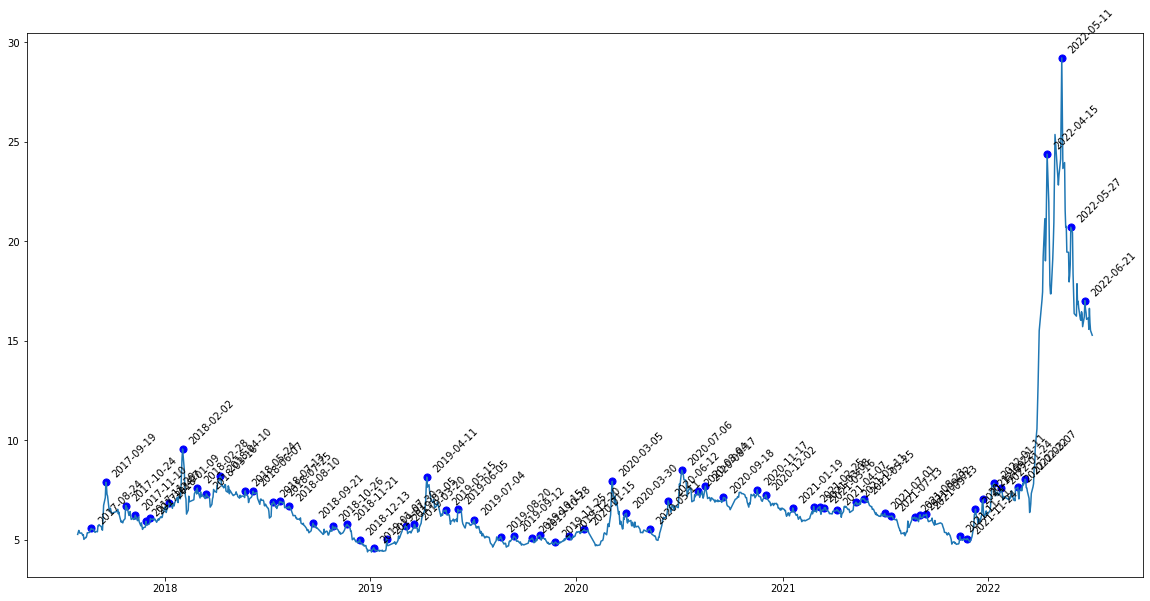

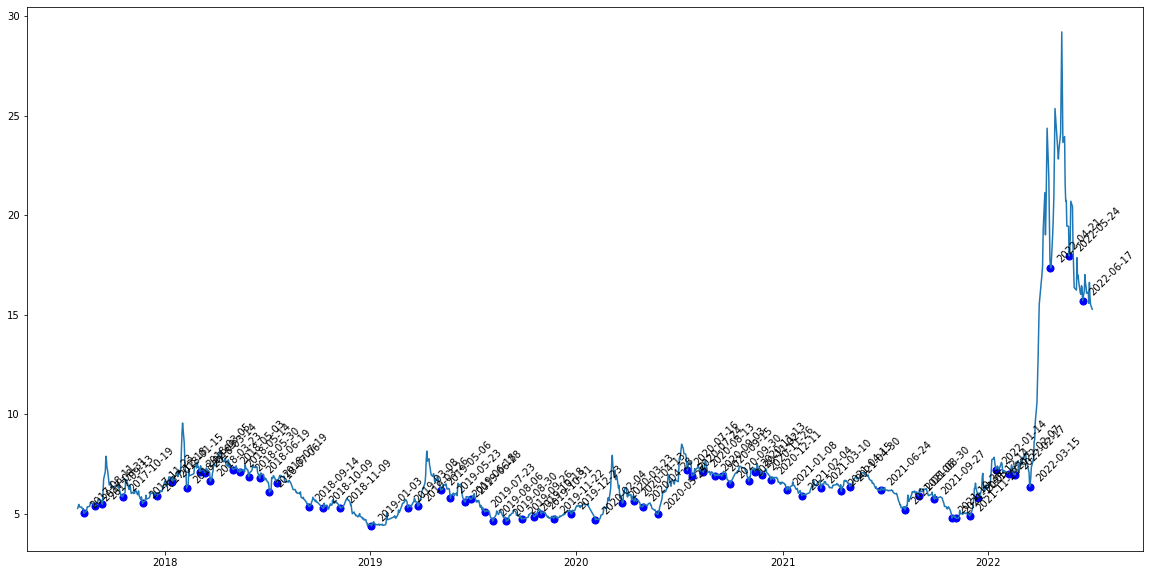

In [20]:
def get_limit_date(df,win_s=2):
    max = []
    min = []
    index = df.index.values
    for i in range(win_s,len(index)-win_s):
        if df.loc[index[i-win_s]:index[i-1],'close'].max()<df.loc[index[i],'close'] and df.loc[index[i+1]:index[i+win_s],'close'].max()<df.loc[index[i],'close']:
            max.append(df.loc[index[i],'date'])
        if df.loc[index[i-win_s]:index[i-1],'close'].min()>df.loc[index[i],'close'] and df.loc[index[i+1]:index[i+win_s],'close'].min()>df.loc[index[i],'close']:
            min.append(df.loc[index[i],'date'])
    return {'max':max,'min':min}
dates = get_limit_date(zjdc,win_s=5)
draw_limit(zjdc,dates,'max')
draw_limit(zjdc,dates,'min')

## 计算买入卖出点

In [21]:
def get_bs_point(dates):
    max = dates['max']
    min = dates['min']
    bs_points = []
    i = 0
    while i < len(min):
        min_date = min[i]
        j = 0
        if i < len(min) -1:
            while j < len(max) and max[j] < min[i+1]:
                if max[j] > min[i]:
                    bs_points.append((min[i],max[j]))
                    break;
                j = j+1
        else:
            while j < len(max):
                if max[j] > min[i]:
                    bs_points.append((min[i],max[j]))
                    break;
                j = j+1
        i = i + 1
    return bs_points

In [22]:
bs_points = get_bs_point(dates)

In [23]:
bs_points

[('2017-08-11', '2017-08-24'),
 ('2017-09-13', '2017-09-19'),
 ('2017-10-19', '2017-10-24'),
 ('2017-11-23', '2017-11-29'),
 ('2017-12-18', '2018-01-09'),
 ('2018-01-15', '2018-02-02'),
 ('2018-02-09', '2018-02-28'),
 ('2018-03-14', '2018-03-16'),
 ('2018-03-23', '2018-04-10'),
 ('2018-05-14', '2018-05-24'),
 ('2018-05-30', '2018-06-07'),
 ('2018-07-06', '2018-07-13'),
 ('2018-07-19', '2018-07-25'),
 ('2018-09-14', '2018-09-21'),
 ('2018-10-09', '2018-10-26'),
 ('2018-11-09', '2018-11-21'),
 ('2019-01-03', '2019-01-07'),
 ('2019-03-08', '2019-03-20'),
 ('2019-03-26', '2019-04-11'),
 ('2019-05-06', '2019-05-15'),
 ('2019-05-23', '2019-06-05'),
 ('2019-06-28', '2019-07-04'),
 ('2019-08-06', '2019-08-20'),
 ('2019-08-30', '2019-09-12'),
 ('2019-09-26', '2019-10-15'),
 ('2019-10-18', '2019-10-28'),
 ('2019-11-22', '2019-11-25'),
 ('2019-12-23', '2020-01-15'),
 ('2020-02-04', '2020-03-05'),
 ('2020-03-23', '2020-03-30'),
 ('2020-04-28', '2020-05-11'),
 ('2020-05-25', '2020-06-12'),
 ('2020-

In [24]:
# 去除收益率低于5%的点
def delete_low_return_rate(df,points):
    result = []
    for point in points:
        buy_price = df[df['date']==point[0]]['close'].values[0]
        sell_price = df[df['date']==point[1]]['close'].values[0]
        rate = (sell_price - buy_price)/buy_price
        if rate > 0.05:
            result.append(point)
            print(point,rate)
    return result

In [25]:
bs_points = delete_low_return_rate(zjdc,bs_points)

('2017-08-11', '2017-08-24') 0.10956175298804796
('2017-09-13', '2017-09-19') 0.43978102189781004
('2017-10-19', '2017-10-24') 0.14871794871794874
('2017-11-23', '2017-11-29') 0.07427536231884062
('2017-12-18', '2018-01-09') 0.16666666666666674
('2018-01-15', '2018-02-02') 0.452887537993921
('2018-02-09', '2018-02-28') 0.20826709062003174
('2018-03-23', '2018-04-10') 0.23192771084337352
('2018-05-14', '2018-05-24') 0.052186177715091694
('2018-05-30', '2018-06-07') 0.08296943231441052
('2018-07-06', '2018-07-13') 0.1362889983579639
('2018-07-19', '2018-07-25') 0.05479452054794512
('2018-09-14', '2018-09-21') 0.08971962616822439
('2018-10-09', '2018-10-26') 0.07969639468690719
('2018-11-09', '2018-11-21') 0.09280303030303017
('2019-01-03', '2019-01-07') 0.05022831050228305
('2019-03-08', '2019-03-20') 0.08662900188323917
('2019-03-26', '2019-04-11') 0.5148698884758365
('2019-05-06', '2019-05-15') 0.05177993527508096
('2019-05-23', '2019-06-05') 0.12975778546712802
('2019-06-28', '2019-07

In [26]:
bs_points

[('2017-08-11', '2017-08-24'),
 ('2017-09-13', '2017-09-19'),
 ('2017-10-19', '2017-10-24'),
 ('2017-11-23', '2017-11-29'),
 ('2017-12-18', '2018-01-09'),
 ('2018-01-15', '2018-02-02'),
 ('2018-02-09', '2018-02-28'),
 ('2018-03-23', '2018-04-10'),
 ('2018-05-14', '2018-05-24'),
 ('2018-05-30', '2018-06-07'),
 ('2018-07-06', '2018-07-13'),
 ('2018-07-19', '2018-07-25'),
 ('2018-09-14', '2018-09-21'),
 ('2018-10-09', '2018-10-26'),
 ('2018-11-09', '2018-11-21'),
 ('2019-01-03', '2019-01-07'),
 ('2019-03-08', '2019-03-20'),
 ('2019-03-26', '2019-04-11'),
 ('2019-05-06', '2019-05-15'),
 ('2019-05-23', '2019-06-05'),
 ('2019-06-28', '2019-07-04'),
 ('2019-08-06', '2019-08-20'),
 ('2019-08-30', '2019-09-12'),
 ('2019-09-26', '2019-10-15'),
 ('2019-10-18', '2019-10-28'),
 ('2019-12-23', '2020-01-15'),
 ('2020-02-04', '2020-03-05'),
 ('2020-03-23', '2020-03-30'),
 ('2020-05-25', '2020-06-12'),
 ('2020-07-24', '2020-08-04'),
 ('2020-08-13', '2020-08-17'),
 ('2020-11-13', '2020-11-17'),
 ('2021-

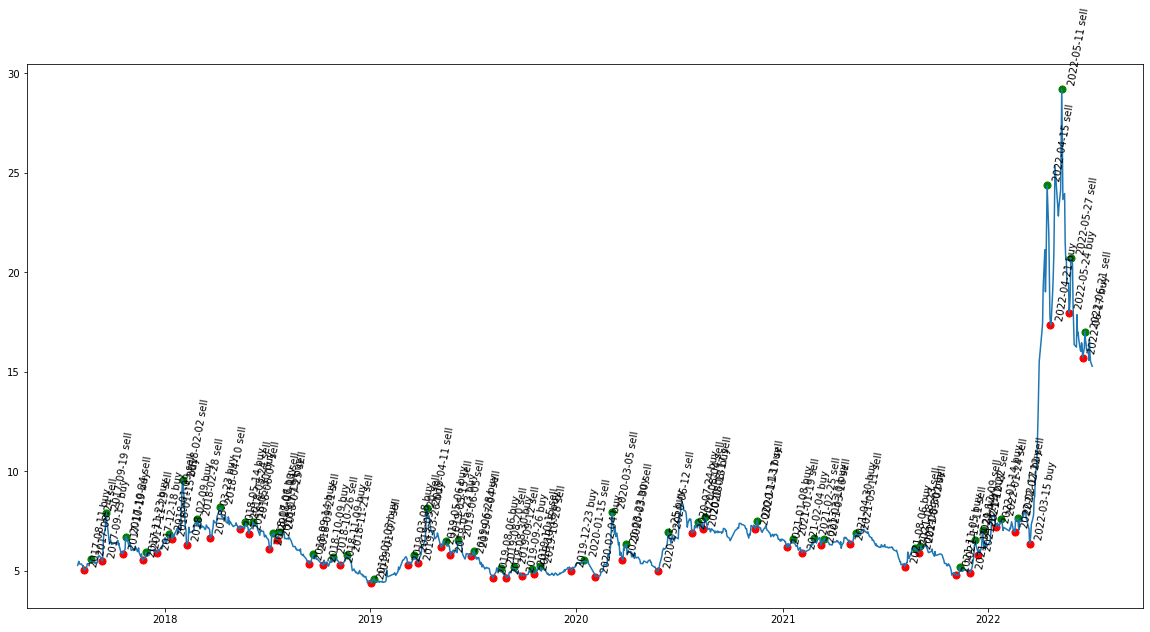

In [27]:
draw_bs_point(zjdc,bs_points)

In [28]:
bs_points

[('2017-08-11', '2017-08-24'),
 ('2017-09-13', '2017-09-19'),
 ('2017-10-19', '2017-10-24'),
 ('2017-11-23', '2017-11-29'),
 ('2017-12-18', '2018-01-09'),
 ('2018-01-15', '2018-02-02'),
 ('2018-02-09', '2018-02-28'),
 ('2018-03-23', '2018-04-10'),
 ('2018-05-14', '2018-05-24'),
 ('2018-05-30', '2018-06-07'),
 ('2018-07-06', '2018-07-13'),
 ('2018-07-19', '2018-07-25'),
 ('2018-09-14', '2018-09-21'),
 ('2018-10-09', '2018-10-26'),
 ('2018-11-09', '2018-11-21'),
 ('2019-01-03', '2019-01-07'),
 ('2019-03-08', '2019-03-20'),
 ('2019-03-26', '2019-04-11'),
 ('2019-05-06', '2019-05-15'),
 ('2019-05-23', '2019-06-05'),
 ('2019-06-28', '2019-07-04'),
 ('2019-08-06', '2019-08-20'),
 ('2019-08-30', '2019-09-12'),
 ('2019-09-26', '2019-10-15'),
 ('2019-10-18', '2019-10-28'),
 ('2019-12-23', '2020-01-15'),
 ('2020-02-04', '2020-03-05'),
 ('2020-03-23', '2020-03-30'),
 ('2020-05-25', '2020-06-12'),
 ('2020-07-24', '2020-08-04'),
 ('2020-08-13', '2020-08-17'),
 ('2020-11-13', '2020-11-17'),
 ('2021-

## 数据标注

In [29]:
# 将买点，标注为1
# 将卖点，标注为-1
# 其他点，标注为0

In [46]:
tmp_df = zjdc.copy()

In [47]:
tmp_df['c_y']=0

In [48]:
buy_date = [x[0] for x in bs_points]
sell_date = [x[1] for x in bs_points]
tmp_df.loc[tmp_df['date'].isin(buy_date),'c_y']=1
tmp_df.loc[tmp_df['date'].isin(sell_date),'c_y']=-1

In [49]:
tmp_df[tmp_df['date'].isin(sell_date)][['date','c_y']]

,date,c_y
18,2017-08-24,-1
36,2017-09-19,-1
56,2017-10-24,-1
82,2017-11-29,-1
110,2018-01-09,-1
128,2018-02-02,-1
141,2018-02-28,-1
168,2018-04-10,-1
198,2018-05-24,-1
208,2018-06-07,-1


# 使用决策树进行分类

In [50]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [54]:
def get_train_data(df,y_column,split_date):
    df = df.dropna()
    columns = list(df.columns.values)
    columns.remove(y_column)
    columns.remove('date')
    train_x = df[df['date']<split_date][columns]
    train_y = df[df['date']<split_date][y_column]
    test_x = df[df['date']>=split_date][columns]
    test_y = df[df['date']>=split_date][y_column]
    
    return {"train_x":train_x,"train_y":train_y,"test_x":test_x,"test_y":test_y}

In [55]:
datas = get_train_data(tmp_df,'c_y','2022-05-20')

In [56]:
split_date='2022-05-20'
y_column='c_y'
df = tmp_df.dropna()
columns = list(df.columns.values)
columns.remove(y_column)
columns.remove('date')
train_x = df[df['date']<split_date][columns]
train_y = df[df['date']<split_date][y_column]
test_x = df[df['date']>=split_date][columns]
test_y = df[df['date']>=split_date][y_column]

In [59]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(datas['train_x'], datas['train_y'])

In [60]:
predict = clf.predict(datas['test_x'])

In [43]:
predict

array([ 0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  1,  0,  1,  1,  0,
        0,  1,  1, -1,  0,  0,  1,  1,  0,  1,  0,  1,  1,  1])

In [72]:
result = tmp_df.loc[datas['test_x'].index,['date','close']]

In [73]:
result['predict']= predict

In [74]:
result

,date,close,predict
1166,2022-05-20,19.46,0
1167,2022-05-23,19.45,0
1168,2022-05-24,17.96,1
1169,2022-05-25,18.26,0
1170,2022-05-26,18.82,0
1171,2022-05-27,20.71,0
1172,2022-05-30,20.44,1
1173,2022-05-31,18.39,0
1174,2022-06-01,17.30,0
1175,2022-06-02,16.37,0


In [81]:
def draw_bs(df):
    label = 'close'
    plt.figure(figsize=(20,10))
    x = pd.to_datetime(df['date'])
    y = df[label].values
    plt.plot(x,y,label=label)
    xb = []
    xs = []
    yb = []
    ys = []
    xtext = []
    xb = pd.to_datetime(df[df['predict']==1]['date'].values)
    xs = pd.to_datetime(df[df['predict']==-1]['date'].values)
    yb = df[df['predict']==1]['close'].values
    ys = df[df['predict']==-1]['close'].values
    
    for i in range(len(xb)):
        plt.annotate(xb[i].strftime('%Y-%d-%m')+' '+'buy',xy=(xb[i],yb[i]),xytext=(+5,+5), textcoords='offset points',rotation=80)
    for i in range(len(xs)):
        plt.annotate(xs[i].strftime('%Y-%d-%m')+' '+'sell',xy=(xs[i],ys[i]),xytext=(+5,+5), textcoords='offset points',rotation=80)

    plt.scatter(xb,yb,s=50,color='r')
    plt.scatter(xs,ys,s=50,color='g')

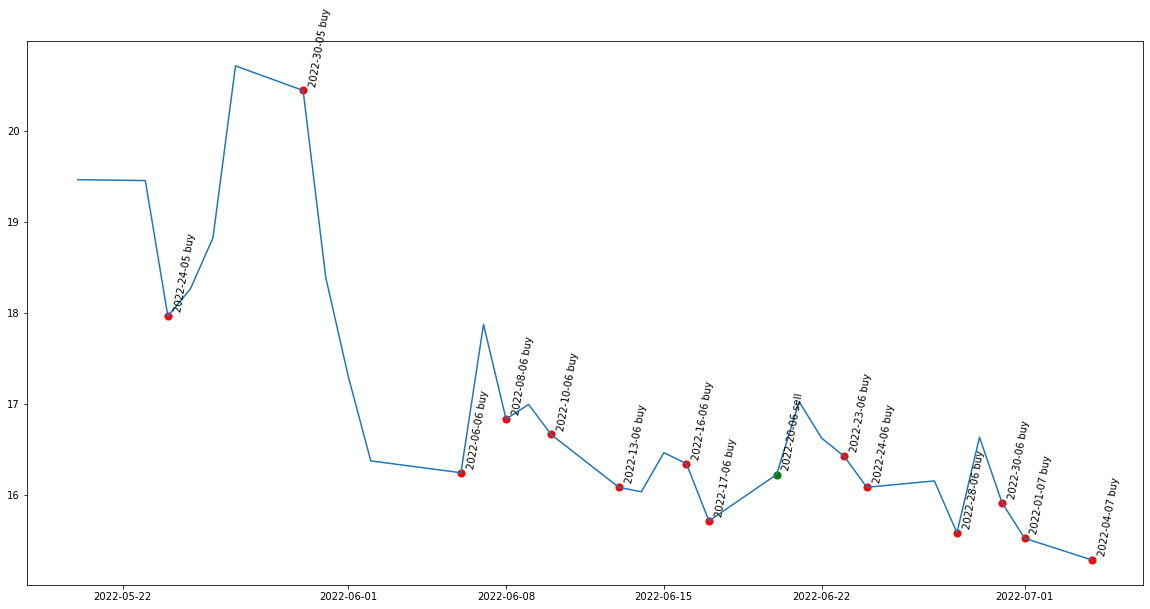

In [82]:
draw_bs(result)

# 改进-预测第二天的股价